In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from numpy.fft import fft2, ifft2, fftshift, ifftshift
import time

import sys
import glob
from PIL import Image
import pickle
import os
from skimage import io
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

import waveorder as wo


%matplotlib inline
plt.style.use(['dark_background']) # Plotting option for dark background


In [20]:
#Adapted from Li-Hao's visual.py
def hyper_stack_viewer(image_stack, slices, time, size=(10,10), colormap='gray', phase = False):
    
    '''
    Visualize xyzt stacks.
    image_stack: Stack of images in xyzt order 
    slices: the number of slices
    time: the number of timepoints
    Example data: 
        [imgz0t0, imgz1t0, img z2t0, imgz0t1, imgz1t1, img z2t1]
        slices = 3
        time = 2
    '''
    if phase == True:
        max_val = 2.5
        min_val = -1.5
    else:
        max_val = np.percentile(image_stack, 99.99)
        min_val = np.min(image_stack)

    def interact_plot_4D(z, t):    
        plt.figure(figsize=size)
        plt.imshow(image_stack[t*slices + z],cmap=colormap, vmin=min_val, vmax=max_val)
        plt.colorbar()
    
    return interact(interact_plot_4D, z=widgets.IntSlider(value=0, min=0, max=slices-1, step=1),
                    t=widgets.IntSlider(value=0, min=0, max=time, step=1))

In [21]:
n_media       = 1.512               # refractive index of the immersed media for objective (oil: 1.512, water: 1.33, air: 1)
lambda_illu   = 0.532               # illumination wavelength (um)
mag           = 63                  # magnification of the microscope                      
NA_obj        = 1.47                # detection NA of the objective
NA_illu       = 0.4                 # illumination NA of the condenser
N_defocus     = 5                   # number of defocus images
N_channel     = 5                   # number of Polscope channels
z_step        = 1               # z_step of the stack
z_defocus     = -(np.r_[:N_defocus]-N_defocus//2)*z_step
chi           = 0.03*2*np.pi        # swing of the LC
ps            = 6.45/mag            # effective pixel size at the sample plane (cam pix/mag in um)
cali          = True                # correction for S1/S2 Polscope reconstruction (does not affect phase)
bg_option     = 'local_fit'         # background correction method for Polscope recon (does not affect phase)
data_path     = '/gpfs/CompMicro/Hummingbird/RawData/Interns/2019_07_22/U2OS untreated_1/' # data path
bg_path       = '/gpfs/CompMicro/Hummingbird/RawData/Interns/2019_07_22/Empty_Background/Pos0/'# background data path
output_path   = '/gpfs/CompMicro/Projects/nucleolus/labelfree_segmentation/phase_recon/7_22_19_6well_lower_phase/'# output image path
use_gpu = True

In [22]:
data_paths = sorted(glob.glob(data_path + "/*/"))
N_Pos = len(data_paths)

In [23]:
output_paths = [output_path + "Pos" + str(i) + "/" for i in range(N_Pos)]

In [24]:
# solver option

deconv = 'TV'         # deconvolution method

if deconv == 'Tikhonov':
    reg_u = 1e-1      # absorption regularizer (larger the smoother but less contrast)
    reg_p = 1e-3      # phase regularizer
    
elif deconv == 'TV':
    lambda_u = 1e-2   # absorption regularizer
    lambda_p = 1e-2   # phase regularizer
    rho = 1           # rho coefficient of ADMM algorithm (the larger the less noisy and contrast)
    itr = 10          # number of ADMM iteration (10 is usually good)
    verbose = False   # report of the iteration number or not

In [35]:
# Plot setting

max_phase = 2                     # maximum phase value to display
min_phase = -0.5                     # minimum phase value to display

max_ret   = 2.5e-3/lambda_illu*2*np.pi # maximum retardance value
all_z     = False                    # plot all z birefringence or not
z_layer   = 3                        # focal layer to plot if only plot single layer
recon_birefringence = False           # Reconstruct birefringence?
recon_phase = True                  # Reconstruct phase?
lambdas = [1e-1,1e-2,1e-3]

In [26]:
files = {}
for i in np.arange(N_Pos):
    files[i] = sorted(glob.glob(data_paths[i] + '*0[0-5][0-9]_state*.tif'))

In [27]:
filedir_bg = bg_path + '*Acquired*.tif'
files_bg = sorted(glob.glob(filedir_bg), key=wo.numericalSort)

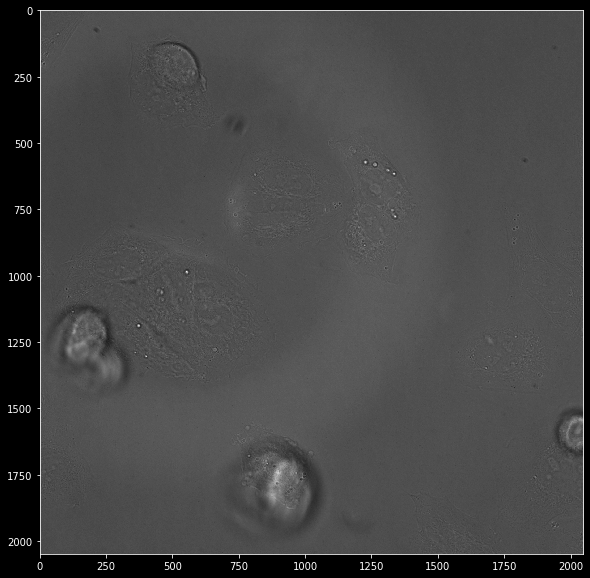

In [28]:
# select a FOV for processing

# Ns = 600
# Ms = 600
# n_start = [550, 1400] 

Ns = 2048
Ms = 2048
n_start = [0, 0] 


plt.figure(figsize=(10,10))
plt.imshow(io.imread(files[0][0]).astype('float64')[n_start[0]:n_start[0]+Ns, n_start[1]:n_start[1]+Ms], cmap = 'gray')


In [10]:
setup = wo.waveorder_microscopy((Ns,Ms), lambda_illu, ps, NA_obj, NA_illu, z_defocus, chi,\
                                n_media=n_media, cali=cali, bg_option=bg_option)

In [39]:

Nimg = N_defocus*N_channel
N_time = len(files)//Nimg

# Load background images
Nbg = len(files_bg)
I_bg_pre = []

for i in range(0, Nbg):
    Itemp = io.imread(files_bg[i]).astype('float64')[n_start[0]:n_start[0]+Ns, n_start[1]:n_start[1]+Ms]
    I_bg_pre.append(Itemp)

I_bg_pre = np.array(I_bg_pre)

I_bg = np.zeros_like(I_bg_pre)
I_bg = wo.intensity_mapping(I_bg_pre)

m = 0
# Load Polscope images
I_meas_pre =[]

for i in range(0, Nimg):
    Itemp = io.imread(files[0][m*Nimg+i]).astype('float64')[n_start[0]:n_start[0]+Ns, n_start[1]:n_start[1]+Ms]
    I_meas_pre.append(Itemp)
    sys.stdout.write("\r" + "Loaded Polscope image " + str(i))
    sys.stdout.flush()
I_meas_pre = np.array(I_meas_pre)
I_meas_pre = np.transpose(I_meas_pre.reshape((N_channel, N_defocus, Ns, Ms)), (0,2,3,1))

# intensity mapping to match the theory
I_meas = np.zeros_like(I_meas_pre)
for i in range(N_defocus):
    I_meas[:,:,:,i] = wo.intensity_mapping(I_meas_pre[:,:,:,i])
    sys.stdout.write("\r" + "Intensity mapping " + str(i))
    sys.stdout.flush()

# Stokes vector recon with bg correction
S_image_recon = setup.Stokes_recon(I_meas)
S_bg_recon = setup.Stokes_recon(I_bg)


S_image_tm = setup.Stokes_transform(S_image_recon,use_gpu=use_gpu)
S_bg_tm = setup.Stokes_transform(S_bg_recon,use_gpu=use_gpu)


S_image_tm = setup.Polscope_bg_correction(S_image_tm, S_bg_tm, use_gpu=use_gpu)  


Recon_para = setup.Polarization_recon(S_image_tm,use_gpu=use_gpu)



# Take out S0 for phase reconstruction
S0_stack = S_image_tm[0].copy()

phase_imgs = []
for mu in lambdas:
    print("Test " + str(mu))
    if deconv == 'Tikhonov':
        mu_sample, phi_sample = setup.Phase_recon(S0_stack, method='Tikhonov', reg_u = mu, reg_p = reg_p, use_gpu=use_gpu)

    elif deconv == 'TV':
        mu_sample, phi_sample = setup.Phase_recon(S0_stack, method='TV', lambda_u = mu, lambda_p = lambda_p, \
                                              itr = itr, rho=rho, verbose = verbose, use_gpu=use_gpu)
    #file_name_phase = output_path+'phase/'+raw_imgs[m].split('state')[0].rsplit('/')[-1]+str(mu)+'phase.tiff'
phase_imgs.append(phi_sample)

phase_imgs = np.array(phase_imgs)


Intensity mapping 4ge 24Test 0.1
Test 0.01
Test 0.001


SyntaxError: 'return' outside function (<ipython-input-39-b16ca4bd03ba>, line 68)

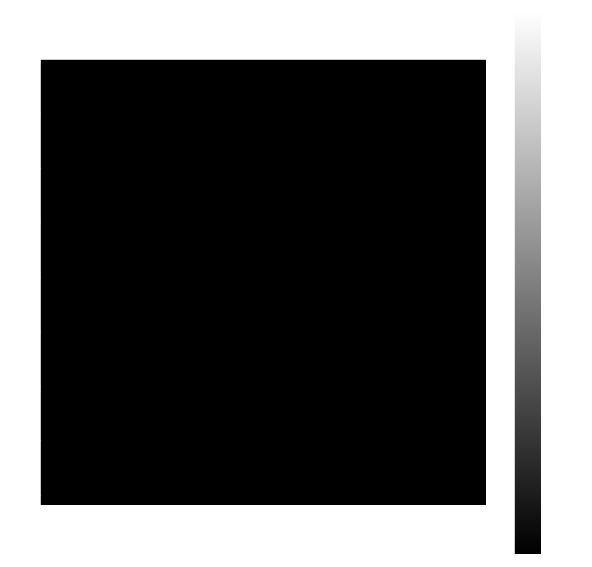

<function __main__.hyper_stack_viewer.<locals>.interact_plot_4D(z, t)>

In [17]:
hyper_stack_viewer(test,3,1)

In [ ]:
def recon_phase_pos(pos):
    for m in range(N_time):
        # Load Polscope images
        I_meas_pre =[]

        for i in range(0, Nimg):
            Itemp = io.imread(files[m*Nimg+i]).astype('float64')[n_start[0]:n_start[0]+Ns, n_start[1]:n_start[1]+Ms]
            I_meas_pre.append(Itemp)
        I_meas_pre = np.array(I_meas_pre)
        I_meas_pre = np.transpose(I_meas_pre.reshape((N_channel, N_defocus, Ns, Ms)), (0,2,3,1))

        # intensity mapping to match the theory
        I_meas = np.zeros_like(I_meas_pre)
        for i in range(N_defocus):
            I_meas[:,:,:,i] = wo.intensity_mapping(I_meas_pre[:,:,:,i])


        # Stokes vector recon with bg correction
        S_image_recon = setup.Stokes_recon(I_meas)
        S_bg_recon = setup.Stokes_recon(I_bg)


        S_image_tm = setup.Stokes_transform(S_image_recon,use_gpu=use_gpu)
        S_bg_tm = setup.Stokes_transform(S_bg_recon,use_gpu=use_gpu)


        S_image_tm = setup.Polscope_bg_correction(S_image_tm, S_bg_tm, use_gpu=use_gpu)  


        Recon_para = setup.Polarization_recon(S_image_tm,use_gpu=use_gpu)



        # Take out S0 for phase reconstruction
        S0_stack = S_image_tm[0].copy()


        # Phase reconstruction

        if deconv == 'Tikhonov':
            mu_sample, phi_sample = setup.Phase_recon(S0_stack, method='Tikhonov', reg_u = reg_u, reg_p = reg_p, use_gpu=use_gpu)

        elif deconv == 'TV':
            mu_sample, phi_sample = setup.Phase_recon(S0_stack, method='TV', lambda_u = lambda_u, lambda_p = lambda_p, \
                                                      itr = itr, rho=rho, verbose = verbose, use_gpu=use_gpu)


        # figure plotting as tiff files\
        file_name_phase = output_paths[pos]+'phase/'+files[pos][m*Nimg].split('state')[0].rsplit('/')[-1]+'phase.tiff'
        plt.imsave(file_name_phase, phi_sample, format="tiff", cmap=plt.cm.gray, vmin=min_phase, vmax=max_phase)

        if all_z == True:
            for i in range(N_defocus):

                bi_hsv = np.transpose(np.array([Recon_para[1,:,:,i]/np.pi, \
                                                   np.ones((Ns,Ms)), \
                                                   np.clip(Recon_para[0,:,:,i]/max_ret,0,1)]), (1,2,0))
                bi_rgb = hsv_to_rgb(bi_hsv.copy())

                file_name_bire = output_path[pos]+'birefringence/'+files[pos][m*Nimg+i].split('state0')[0].split('/')[1]\
                                    +files[pos][m*Nimg+i].split('state0')[1].split('.')[0]+'_birefringence.tiff'
                plt.imsave(file_name_bire, bi_rgb, format="tiff")

        elif recon_birefringence == True:
                bi_hsv_1 = np.transpose(np.array([Recon_para[1,:,:,z_layer]/np.pi, \
                                                   np.ones((Ns,Ms)), \
                                                   np.clip(Recon_para[0,:,:,z_layer]/max_ret,0,1)]), (1,2,0))
                norm_phase = np.clip(phi_sample, min_phase, max_phase)-min_phase
                norm_phase /= np.max(norm_phase)
                bi_hsv_2 = np.transpose(np.array([Recon_para[1,:,:,z_layer]/np.pi, \
                                                   np.clip(Recon_para[0,:,:,z_layer]/max_ret,0,1), \
                                                   norm_phase]), (1,2,0))
                bi_rgb_temp = hsv_to_rgb(bi_hsv_1.copy())
                bi_rgb_1 = bi_rgb_temp.copy()


                bi_rgb_temp = hsv_to_rgb(bi_hsv_2.copy())
                bi_rgb_2 = bi_rgb_temp.copy()


                file_name_bire = output_path[pos]+'birefringence/'+files[m*Nimg+z_layer].split('state0')[0].rsplit('/')[-1]\
                                        +files[pos][m*Nimg+z_layer].split('state0')[1].split('.')[0]+'_birefringence.tiff'
                plt.imsave(file_name_bire, bi_rgb, format="tiff")



        print('Number of image stacks processed (%d / %d)'%(m+1,N_time))

## After testing, run this

In [ ]:
os.system('mkdir '+output_path)
os.system('mkdir '+output_path+'phase')
os.system('mkdir '+output_path+'birefringence')
os.system('mkdir '+output_path+'birefringence2')

init_time = time.time()

Nimg = N_defocus*N_channel
N_time = len(files)//Nimg

# Load background images
Nbg = len(files_bg)
I_bg_pre = []

for i in range(0, Nbg):
    Itemp = io.imread(files_bg[i]).astype('float64')[n_start[0]:n_start[0]+Ns, n_start[1]:n_start[1]+Ms]
    I_bg_pre.append(Itemp)

I_bg_pre = np.array(I_bg_pre)

I_bg = np.zeros_like(I_bg_pre)
I_bg = wo.intensity_mapping(I_bg_pre)


Parallel(n_jobs = 5, verbose = 10)(delayed(recon_phase_position)(pos) for pos in range(N_Pos))

Number of image stacks processed (1 / 25)
Number of image stacks processed (2 / 25)
Number of image stacks processed (3 / 25)
Number of image stacks processed (4 / 25)
Number of image stacks processed (5 / 25)
Number of image stacks processed (6 / 25)
Number of image stacks processed (7 / 25)
Number of image stacks processed (8 / 25)
Number of image stacks processed (9 / 25)
Number of image stacks processed (10 / 25)
Number of image stacks processed (11 / 25)
Number of image stacks processed (12 / 25)
